In [21]:
import numpy as np 
from scipy import linalg
import matplotlib.pyplot as plt
from scipy import interpolate

In [2]:
def upwelling_radiation(j, emissivities):
    emissivities_for_each_layer = []
    for l in range(j, -1, -1):
        #emmisivity of layer j
        E_j = emissivities[j] 
        
        # emmisivity of source layer (index j minus l minus one)
        if j-l-1 == -1:
            E_jmlm1 = 0.0 
        else:
            E_jmlm1 = emissivities[j-l-1]

        # For layers that are not j or source, find effective emmisivity after absorption 
        effective_emissivity_of_transmission_layers = []
        for k in range(j-l, j):
            fraction_of_emissivity_transfered = 1 - (emissivities[k])
            effective_emissivity_of_transmission_layers.append(fraction_of_emissivity_transfered)
         
        # Multiply all the effective emissivities of transmission layers, to get one final effective emissivity
        if len(effective_emissivity_of_transmission_layers) == 0:
            product_of_transmission_layers = 1
        elif len(effective_emissivity_of_transmission_layers) > 0:
            product_of_transmission_layers = np.prod(effective_emissivity_of_transmission_layers)
            
        #Now multiply the source and reciving layers by the effective emissivity of the transmission layers
        total_emissivity_product = E_j*E_jmlm1*product_of_transmission_layers
        emissivities_for_each_layer.append(total_emissivity_product)
        
    # return the emissivities of each layer now, but take out first entry which is always zero
    return(emissivities_for_each_layer[1:])


def R_up_matrix(N, emissivities):
    empty_Np1_Np1_array = np.zeros((N+1,N+1))
    # We need to change elements of array based off the row 
    for j in range(0, N+1):
        row_to_change = empty_Np1_Np1_array[j]
        
        # Find emissivities associated with upwelling radiation
        upwelling_terms = upwelling_radiation(j, emissivities)
        
        # Diagonal elements should still remain zero, we will deal with this later
        if len(upwelling_terms) == 0:
            continue
        
        elif len(upwelling_terms) > 0:
            # Here we will change each element in our matrix that corresponds to upwelling radiation
            # In the end, this will only make us have a lower triangular matrix with a diagonal of zero
            for upwelling_idx, upwelling_emissivity in enumerate(upwelling_terms):
                row_to_change[upwelling_idx] = upwelling_emissivity
            row_of_upwelling_radiation = row_to_change
                
        # After the row is changed to the upwelling values, put this row into our matrix
        empty_Np1_Np1_array[j] = row_of_upwelling_radiation
    
    # Now we have an upwelling radiation matrix, which has a zero diagonal and is lower triangular!
    upwelling_radiation_matrix = np.matrix(empty_Np1_Np1_array)
    return(upwelling_radiation_matrix)
    
    
def emissivity_matrix(R_up_matrix, emissivities):
    # downwelling radiation matrix is transpose of upwelling
    R_down_matrix = R_up_matrix.T
    
    # The sum of the upwelling and downwelling radiation is the recieved radiation matrix
    # This matrix does not account for the emitted radiation of each layer, or the forcings
    recieved_radiation_matrix = R_up_matrix + R_down_matrix
    
    # We need to add in the diagonal to the recieved radiation matrix, the diagonal accounts for emitted
    # radiation of each layer, it should have opposite sign than recieved radiation.
    # Unbounded layers eminate both up and down, so all layers besides surface should be multiplied by 2.
    emissivities_diagonal = -2*np.diag(emissivities)
    emissivities_diagonal[0][0] = -1
    
    # total emissivity matrix will be sum of both radiation recieved and radiation emmitted! 
    emissivity_matrix = recieved_radiation_matrix + emissivities_diagonal
    return(emissivity_matrix)

def vertical_heat_flux_profile(N, total_vertical_heat_flux, profile_type):
    number_of_layers = N+1
    # Stratosphere will be only radiatively coupled, so only have heatflux for bottom 85% of layers
    number_of_layers_w_heat_flux = int(number_of_layers*0.85)
    
    if profile_type == 'linear':
        linearly_decreasing_heat_flux = np.linspace(1, 0, number_of_layers_w_heat_flux)
        normalized_linear_decreasing_heat_flux = linearly_decreasing_heat_flux/np.sum(linearly_decreasing_heat_flux)

        # Now we can create the heat flux profile which spans the first 85% of layers and sums to total heat flux
        actual_lin_dec_heat_flux_profile = normalized_linear_decreasing_heat_flux*total_vertical_heat_flux
        total_atmospheric_heatflux_profile = np.zeros(number_of_layers)

        total_atmospheric_heatflux_profile[:number_of_layers_w_heat_flux] = actual_lin_dec_heat_flux_profile
        #downward_flux = np.insert(total_atmospheric_heatflux_profile[:-1], 0, 0)
        return(total_atmospheric_heatflux_profile)#, downward_flux)
    elif profile_type == 'exponential':
        exponentially_decreasing_heat_flux = np.geomspace(1, 1e-5, number_of_layers_w_heat_flux)
        normalized_exp_decreasing_heat_flux = exponentially_decreasing_heat_flux/np.sum(exponentially_decreasing_heat_flux)

        # Now we can create the heat flux profile which spans the first 85% of layers and sums to total heat flux
        actual_exp_dec_heat_flux_profile = normalized_exp_decreasing_heat_flux*total_vertical_heat_flux
        total_atmospheric_heatflux_profile = np.zeros(number_of_layers)

        total_atmospheric_heatflux_profile[:number_of_layers_w_heat_flux] = actual_exp_dec_heat_flux_profile
        #downward_flux = np.insert(total_atmospheric_heatflux_profile[:-1], 0, 0)
        return(total_atmospheric_heatflux_profile)#, downward_flux)

def forcings_vector(N, insolation, heat_flux_profile):
    # Let all the forcings be zero for now, besides the insolation
    forcings = np.zeros(N+1)
    forcings[0] = insolation*-1
    net_forcings = forcings - heat_flux_profile
    
    
    # Forcings should also be scaled by 1/sigma
    sigma = 5.67e-8 # W * m^-2 * K^-4
    
    one_over_sigma = 1/sigma
    
    return(net_forcings*one_over_sigma)

def temperature(total_emissivity_matrix, forcings):
    """
    We have an matrix equation of (total_emissivity_matrix) X (T_i^4) = F_i
    Where total emissivity matrix is N+1 x N+1, T_i^4 is a column vector of N+1 and 
    forcings are another column vector, scaled by 1/sigma.
    """
    
    inverse_of_emissivity_matrix = linalg.inv(total_emissivity_matrix)
    temperature_vector = forcings.dot(inverse_of_emissivity_matrix)
    return(np.array(temperature_vector)**(1/4))

In [3]:
def __init__(self):
        """
        
        Collect scalable physical parameters to be used for the N-Layer radiative model.
        
        """
        self.N_slider = widgets.IntSlider(min=1, max=100, value=2, description='N-Layers: ')
        widgets.interact(self.get_n_slider, N_slider=self.N_slider)
        
        self.albedo_slider = widgets.FloatSlider(min=0, max=1, value=0.3, description='Albedo: ')
        widgets.interact(self.get_albedo_slider, albedo_slider=self.albedo_slider)
        
        self.S0_slider = widgets.IntSlider(min=10, max=10000, value=1368, description='$S_{0}$ ($W/m^2$): ')
        widgets.interact(self.get_S0_slider, S0_slider=self.S0_slider)
        
        self.heatflux_slider = widgets.IntSlider(min=10, max=1000, value=110, 
                                                 description='Heat Flux \nTotal ($W/m^2$): ')
        widgets.interact(self.get_heatflux_slider, heatflux_slider=self.heatflux_slider)
        
        #self.pertub_button = widgets.ToggleButton(value=False, description='Perturbation?',
        #                                         disabled=False, button_style='info',
        #                                         tooltip='Description')
        #widgets.interact(self.get_perturbation, calc_button=self.pertub_button)
        
        self.calc_button = widgets.ToggleButton(value=False, description='Radiate',
                                                 disabled=False, button_style='info',
                                                 tooltip='Description')
        widgets.interact(self.get_temps, calc_button=self.calc_button)

In [4]:
#### THIS GOES INTO UTILS ####
def forcings_vector(N, insolation, heat_flux_profile, SW_stratosphere_absorption):
    # Let all the forcings be zero for now, besides the insolation
    forcings = np.zeros(N+1)
    forcings[0] = insolation*-1
    
    ### VTC EDIT ###
    N_troposphere = np.floor(0.85*N) - 1 ## subtract 1 to allow for tropopause
    N_tpause = 1 ## 1 layer is the tropical tropoause layer
    N_tpause_location = int(0.85*N) # layer number for the TTL
    N_stratosphere = N - N_troposphere - N_tpause
    
    # stratospheric forcing will be spread uniformly over each strat layer
    forcings[N_tpause_location+1:] = -SW_stratosphere_absorption / N_stratosphere
    ### end edit ###
    
    net_forcings = forcings - heat_flux_profile
    
    # Forcings should also be scaled by 1/sigma
    sigma = 5.67e-8 # W * m^-2 * K^-4
    
    one_over_sigma = 1/sigma
    
    return(net_forcings*one_over_sigma)

In [384]:
N = 20
sw_upper = 1*0.03 * self_S0/4 # https://www.e-education.psu.edu/meteo300/node/649, 3% absorbed in Stratosphere

#### THIS GOES INTO GET_TEMPS ####
## separate N into troposphere, tropopause, and stratosphere
N_troposphere = int(0.85*N) - 1 ## subtract 1 to allow for tropopause
N_tpause = 1 ## 1 layer is the tropical tropoause layer
N_tpause_location = int(0.85*N) # layer number for the TTL, including surface as zero index
N_stratosphere = N - N_troposphere - N_tpause
print(N_troposphere, N_tpause, N_stratosphere, N_stratosphere + N_troposphere + N_tpause - N)

## we want M realizations of possible emmisivity profiles for mr. monte carlo
M = 1000
## emissivity profile for each layer
emissivity_surface = np.tile(1,M)
# emissivity_troposphere_M = np.random.uniform(0.2,0.7,(M,N_troposphere))
# emissivity_tpause_M = np.random.uniform(0.1,0.2,M)
# emissivity_stratosphere_M = np.random.uniform(0.001,0.1,(M,N_stratosphere))

# emissivity_troposphere_M = np.random.uniform(0.1,1/np.log(N),(M,N_troposphere))
# emissivity_tpause_M = np.random.uniform(0.01,0.1,M)
# emissivity_stratosphere_M = np.random.uniform(0.01,0.2,(M,N_stratosphere))

# emissivity_troposphere_M = np.random.uniform(0.0001,0.199,(M,N_troposphere))
# emissivity_tpause_M = np.random.uniform(0.0001,0.0199,M)
# emissivity_stratosphere_M = np.random.uniform(0.0001,0.0199,(M,N_stratosphere))

emissivity_troposphere_M = np.random.uniform(0.0001,0.7,(M,N_troposphere))
emissivity_tpause_M = np.random.uniform(0.0001,0.2,M)


# alternative for monotonic decreasing emissivities in tropo
emissivity_troposphere_M_decreasing = np.zeros((M,N_troposphere))
emissivity_troposphere_M_decreasing[:,0] = np.random.uniform(0.2,1,M)
for i in range(N_troposphere-1):
    emissivity_troposphere_M_decreasing[:,i+1] = np.random.uniform(0.01,
                                                                   emissivity_troposphere_M_decreasing[:,i],M)

emissivity_tpause_M = np.random.uniform(0.005,emissivity_troposphere_M_decreasing[:,-1],M)
emissivity_stratosphere_M = np.random.uniform(0.0001,
                                              np.repeat(emissivity_tpause_M[:,np.newaxis],N_stratosphere,axis=1),
                                              (M,N_stratosphere))

emissivity_Nlayers_M = np.vstack([emissivity_surface,
                                  emissivity_troposphere_M_decreasing.T,
                                  emissivity_tpause_M,
                                  emissivity_stratosphere_M.T])

# ## placeholder for temps
# layer_temps_N = np.zeros([layers_N.shape[0]+1, ## add surface temp layer
#                          layers_N.shape[1]])

16 1 3 0


60


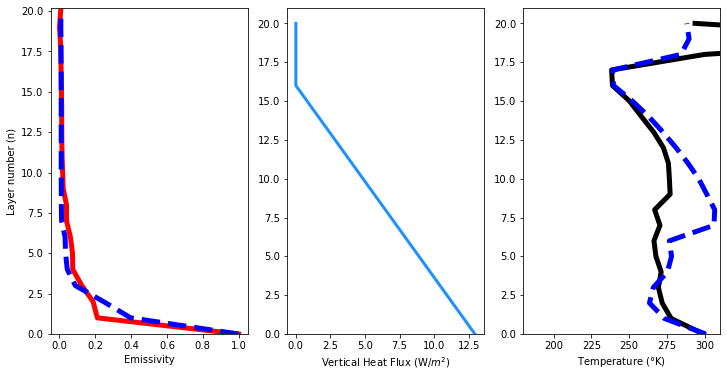

CPU times: user 33.9 s, sys: 1min 9s, total: 1min 43s
Wall time: 6.84 s


In [390]:
%%time
self_S0 = 1368
self_albedo = 0.3
self_heatflux = 1*110
self_N = N

insolation = (self_S0/4)*(1 - self_albedo)

# arrays to hold Monte Carlo values
temperature_M = np.zeros([M,N+1]) # arrays to hold Monte Carlo values

fig, axs = plt.subplots(1,3, figsize=(12,6))
for i,val in enumerate(emissivity_Nlayers_M.T):
#     val = emissivities
    temp_R_up_matrix = R_up_matrix(N, val)
    temp_total_emissivity_matrix = emissivity_matrix(temp_R_up_matrix, val)
            
    temp_upward_heatflux = vertical_heat_flux_profile(N, self_heatflux, 'linear')
            
#     forcings = utils.forcings_vector(self.N, insolation, upward_heatflux)
    temp_forcings = forcings_vector(N, insolation, temp_upward_heatflux, sw_upper)
            
           

    # Now find the temperature vector using the emissivity matrix and the forcings
    temp_temperature_vector = temperature(temp_total_emissivity_matrix, temp_forcings)
    temperature_M[i] = temp_temperature_vector
    
    

    # Emissivities plot
#     axs[0].plot(val, range(0, self_N+1), color='black',alpha=0.01)
#     axs[2].plot(temp_temperature_vector, range(0, self_N+1), color='firebrick', linewidth=3,alpha=0.01)

## selecting the best profile
era5_profile = np.load('tropical_profile.npy')
# era5_profile = np.load('polar_profile.npy')
#         elif self.togglebutton == 'Poles':
#             era5_profile = np.load('polar_profile.npy')
        
era5_N_of_tpause = np.where(np.r_[True, era5_profile[1:] < era5_profile[:-1]] & 
                                np.r_[era5_profile[:-1] < era5_profile[1:], True])[0][0]

era5_layers = np.linspace(0, self_N, 32)
era5_layers_to_tpause = np.linspace(0, N_tpause_location, era5_N_of_tpause)
interp_troposphere = interpolate.interp1d(era5_layers_to_tpause, era5_profile[:era5_N_of_tpause])
profile_for_emissivities_trop = interp_troposphere(np.arange(N_tpause_location+1))

interp_stratosphere = interpolate.interp1d(era5_layers[era5_N_of_tpause:], era5_profile[era5_N_of_tpause:])
profile_for_emissivities_strat = interp_stratosphere(np.arange(N_stratosphere) + N_tpause_location + 1)
profile_for_emissivities_all = np.append(profile_for_emissivities_trop, profile_for_emissivities_strat)

## restrict to accurate surface temperature
## this is a dummy that places -1000 as the surface temp for anything that is
## more than 2 degrees off the surface temperature.
temperature_M_temp = temperature_M.copy()
temperature_M_temp[:,0] = np.where(
    np.abs(profile_for_emissivities_trop[0] - temperature_M[:,0]) < 2, 
    temperature_M[:,0], 
    -1000)
print(np.where(
    np.abs(profile_for_emissivities_trop[0] - temperature_M[:,0]) < 2, 
    1,0).sum())

## find profile that minimizes the squared error relative to era5, only up to the tropopause
error = ((temperature_M_temp[:,:N_tpause_location+1] - profile_for_emissivities_trop)**2).sum(axis=1)
np.where(error == error.min())
best_index = np.where(error == error.min())   

## now include stratosphere in error calc
error = ((temperature_M_temp - profile_for_emissivities_all)**2).sum(axis=1)
np.where(error == error.min())
best_index_all = np.where(error == error.min())

# Emissivities plot
axs[0].plot(emissivity_Nlayers_M[:,best_index].squeeze(), 
            np.arange(self_N+1), color='r', linewidth=5,alpha=1)
axs[0].plot(emissivity_Nlayers_M[:,best_index_all].squeeze(), 
            np.arange(self_N+1), color='b', linewidth=5,alpha=1, ls='--')
axs[0].set_ylabel('Layer number (n)')
axs[0].set_xlabel('Emissivity')
axs[0].set_ylim(0,self_N+0.2)

axs[1].set_xlabel('Vertical Heat Flux (W/$m^2$)')
axs[1].plot(temp_upward_heatflux, np.arange(self_N+1), color='dodgerblue',alpha=1,lw=3)
axs[1].set_ylim(0,self_N+1)

axs[2].plot(temperature_M[best_index].squeeze(), 
            np.arange(self_N+1), color='k', linewidth=5,alpha=1)
axs[2].plot(temperature_M[best_index_all].squeeze(), 
            np.arange(self_N+1), color='b', ls='--',linewidth=5,alpha=1)
axs[2].set_xlabel('Temperature ($\degree$K)')
axs[2].set_ylim(0,self_N+1)
axs[2].set_xlim(180,310)

plt.show()

In [388]:
(emissivity_Nlayers_M[:,best_index_all].squeeze())[N_tpause_location:]

array([0.00904066, 0.00669548, 0.00884223, 0.0056113 ])

In [336]:
profile_for_emissivities_all_temp = np.append(profile_for_emissivities_trop, profile_for_emissivities_strat)
print(temperature_M_temp[best_index])
print(profile_for_emissivities_trop)
print(profile_for_emissivities_all_temp)

[[300.90964688 272.79500046 259.03776656 244.123854   231.34763158]]
[299.31088  290.744785 276.03558  237.58397  193.04915 ]
[299.31088  290.744785 276.03558  237.58397  193.04915  230.15398 ]


In [284]:
era5_layers = np.linspace(0, self_N, 32)
era5_layers_to_tpause = np.linspace(0, N_tpause_location, era5_N_of_tpause)
interp_troposphere = interpolate.interp1d(era5_layers_to_tpause, era5_profile[:era5_N_of_tpause])
profile_for_emissivities_trop = interp_troposphere(np.arange(N_tpause_location+1))

interp_stratosphere = interpolate.interp1d(era5_layers[era5_N_of_tpause:], era5_profile[era5_N_of_tpause:])
profile_for_emissivities_strat = interp_stratosphere(np.arange(N_stratosphere) + N_tpause_location + 1)
profile_for_emissivities_all = np.append(profile_for_emissivities_trop, profile_for_emissivities_strat)

In [285]:
## restrict to accurate surface temperature
## this is a dummy that places -1000 as the surface temp for anything that is
## more than 2 degrees off the surface temperature.
temperature_M_temp = temperature_M.copy()
temperature_M_temp[:,0] = np.where(
    np.abs(profile_for_emissivities_trop[0] - temperature_M[:,0]) < 2, 
    temperature_M[:,0], 
    -1000)
print(np.where(
    np.abs(profile_for_emissivities_trop[0] - temperature_M[:,0]) < 2, 
    1,0).sum())

## now find profile that minimizes the squared error relative to era5, only up to the tropopause
error = ((temperature_M_temp[:,:1+N_tpause_location+1] - profile_for_emissivities_trop)**2).sum(axis=1)
np.where(error == error.min())
temperature_M[np.where(error == error.min())]

38


array([[300.50756493, 271.80315998, 262.58465665, 255.86966318,
        245.09225455, 235.76211426, 229.25698229, 225.12251725,
        220.41685934, 216.65038162, 215.41754572]])

In [240]:
profile_for_emissivities_trop[0]
temperature_M[:,0]

array([0., 0., 0., ..., 0., 0., 0.])

In [162]:
np.where(np.r_[True, era5_profile[1:] < era5_profile[:-1]] & 
                                np.r_[era5_profile[:-1] < era5_profile[1:], True])

era5_N_of_tpause

20

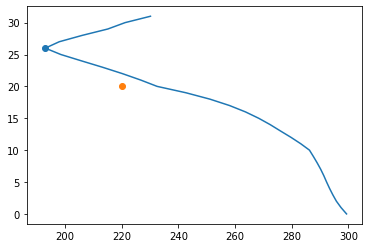

In [211]:
plt.plot(era5_profile,np.arange(len(era5_profile)))
plt.scatter(193,26)
plt.scatter(220,20)

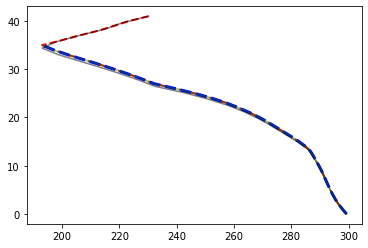

In [210]:
plt.plot(profile_for_emissivities_all,np.arange(len(profile_for_emissivities_all)),c='r',ls='--',lw=2)
plt.plot(profile_for_emissivities_trop,np.arange(len(profile_for_emissivities_trop)),c='b',ls='--',lw=3)
plt.plot(era5_profile,era5_layers,alpha=0.5,c='k')
plt.plot(era5_profile[:era5_N_of_tpause+1],era5_layers_to_tpause,alpha=0.5,c='g')
plt.show()

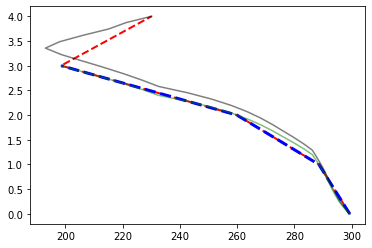

In [371]:
plt.plot(profile_for_emissivities_all,np.arange(len(profile_for_emissivities_all)),c='r',ls='--',lw=2)
plt.plot(profile_for_emissivities_trop,np.arange(len(profile_for_emissivities_trop)),c='b',ls='--',lw=3)
plt.plot(era5_profile,era5_layers,alpha=0.5,c='k')
plt.plot(era5_profile[:era5_N_of_tpause],era5_layers_to_tpause,alpha=0.5,c='g')
plt.show()

In [13]:
# def get_temps(self, calc_button):
def get_temps(self):
        """
        Query whether track button has been toggled, and calculate the radiation matrix before plotting.
        
        """
#         if self.calc_button.value is True:
        dummy = True
        if dummy is True: ## TEMPORARY
            
            # Create some random emissivities to use, surface emissivity is always one, no emissivity should be zero
            emmisivities = np.repeat(.05,self.N+1)
            emmisivities[0] = 1
            
            # Now get our emissivity Matrix
            R_up_matrix = utils.R_up_matrix(self.N, emmisivities)
            total_emissivity_matrix = utils.emissivity_matrix(R_up_matrix, emmisivities)

            # We also need our forcings vector
            insolation = (self.S0/4)*(1 - self.albedo)
            upward_heatflux = utils.vertical_heat_flux_profile(self.N, self.heatflux, 'exponential')
            
            forcings = utils.forcings_vector(self.N, insolation, upward_heatflux)
            
           

            # Now find the temperature vector using the emissivity matrix and the forcings
            temperature_vector = utils.temperature(total_emissivity_matrix, forcings)


            fig, axs = plt.subplots(1,3, figsize=(12,6))

            # Emissivities plot
            axs[0].plot(emmisivities, range(0, self.N+1), color='black')
            axs[0].set_ylabel('Layer number (n)')
            axs[0].set_xlabel('Emissivity')
            axs[0].set_ylim(0,self.N+1)

            axs[1].set_xlabel('Vertical Heat Flux (W/$m^2$)')
            axs[1].plot(upward_heatflux, range(0, self.N+1), color='dodgerblue')
            axs[1].set_ylim(0,self.N+1)

            axs[2].plot(temperature_vector, range(0, self.N+1), color='firebrick', linewidth=3)
            axs[2].set_xlabel('Temperature ($\degree$K)')
            axs[2].set_ylim(0,self.N+1)
            
#             self.calc_button.value = False

1.0


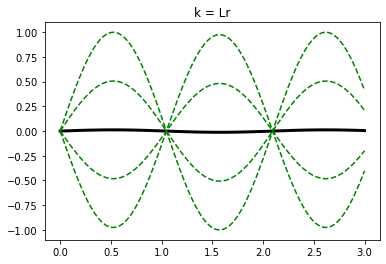

In [272]:
xx = np.linspace(0,3,100)
# Lr = (9.81*1/(10e-4)**2)**1/2
Lr = 1/5
Lr = 3
k = 3
print(Lr/k)

eta1 = ((1 + ((Lr*k)**2)*(1)) / (1 + (Lr*k)**2)) * np.sin(k*xx)
eta15 = ((1 + ((Lr*k)**2)*(1/2)) / (1 + (Lr*k)**2)) * np.sin(k*xx)
eta2 = ((1 + ((Lr*k)**2)*(0)) / (1 + (Lr*k)**2)) * np.sin(k*xx)
eta3 = ((1 + ((Lr*k)**2)*(-1)) / (1 + (Lr*k)**2)) * np.sin(k*xx)
eta35 = ((1 + ((Lr*k)**2)*(-1/2)) / (1 + (Lr*k)**2)) * np.sin(k*xx)
plt.plot(xx,eta2,lw=3,c='k')
plt.plot(xx,eta1,ls='--',c='g')
plt.plot(xx,eta15,ls='--',c='g')
plt.plot(xx,eta35,ls='--',c='g')
plt.plot(xx,eta3,ls='--',c='g')
# plt.xlim(0,100)

# plt.title('k > Lr')
plt.title('k = Lr')
plt.show()

6 2.0


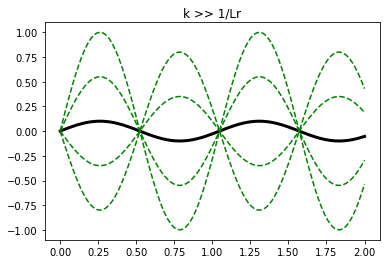

In [352]:
xx = np.linspace(0,2,100)
# Lr = (9.81*1/(10e-4)**2)**1/2
Lr = 1/2
k = 6
print(k,1/Lr)

eta1 = ((1 + ((Lr*k)**2)*(1)) / (1 + (Lr*k)**2)) * np.sin(k*xx)
eta15 = ((1 + ((Lr*k)**2)*(1/2)) / (1 + (Lr*k)**2)) * np.sin(k*xx)
eta2 = ((1 + ((Lr*k)**2)*(0)) / (1 + (Lr*k)**2)) * np.sin(k*xx)
eta3 = ((1 + ((Lr*k)**2)*(-1)) / (1 + (Lr*k)**2)) * np.sin(k*xx)
eta35 = ((1 + ((Lr*k)**2)*(-1/2)) / (1 + (Lr*k)**2)) * np.sin(k*xx)
plt.plot(xx,eta2,lw=3,c='k')
plt.plot(xx,eta1,ls='--',c='g')
plt.plot(xx,eta15,ls='--',c='g')
plt.plot(xx,eta35,ls='--',c='g')
plt.plot(xx,eta3,ls='--',c='g')
# plt.xlim(0,100)

plt.title('k >> 1/Lr')
# plt.title('k = Lr')
plt.show()

5.0


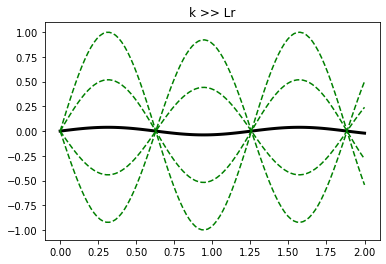

In [332]:
xx = np.linspace(0,2,100)
# Lr = (9.81*1/(10e-4)**2)**1/2
Lr = 1
k = 1/Lr*5
print(Lr*k)

eta1 = ((1 + ((Lr*k)**2)*(1)) / (1 + (Lr*k)**2)) * np.sin(k*xx)
eta15 = ((1 + ((Lr*k)**2)*(1/2)) / (1 + (Lr*k)**2)) * np.sin(k*xx)
eta2 = ((1 + ((Lr*k)**2)*(0)) / (1 + (Lr*k)**2)) * np.sin(k*xx)
eta3 = ((1 + ((Lr*k)**2)*(-1)) / (1 + (Lr*k)**2)) * np.sin(k*xx)
eta35 = ((1 + ((Lr*k)**2)*(-1/2)) / (1 + (Lr*k)**2)) * np.sin(k*xx)
plt.plot(xx,eta2,lw=3,c='k')
plt.plot(xx,eta1,ls='--',c='g')
plt.plot(xx,eta15,ls='--',c='g')
plt.plot(xx,eta35,ls='--',c='g')
plt.plot(xx,eta3,ls='--',c='g')
# plt.xlim(0,100)

plt.title('k >> Lr')
# plt.title('k = Lr')
plt.show()

3 5.0
0.3333333333333333 0.2


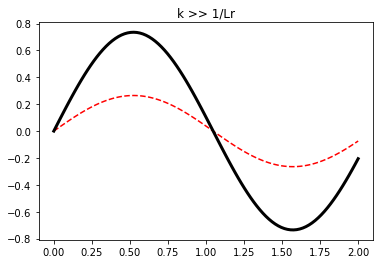

In [369]:
xx = np.linspace(0,2,100)
# Lr = (9.81*1/(10e-4)**2)**1/2

Lr = 1/2
k = 6
plt.title('k >> 1/Lr')

Lr = 1/
k = 3
plt.title('k << 1/Lr')

print(k,1/Lr)
print(1/k,Lr)

eta4 = ((((Lr*k)**2)) / (1 + (Lr*k)**2)) * np.sin(k*xx)
# eta1b = 1 / ((1 + (Lr*k)**2)) * np.sin(k*xx)
# eta2 = ((1 + ((Lr*k)**2)*(0)) / (1 + (Lr*k)**2)) * np.sin(k*xx)
# eta3 = ((1 + ((Lr*k)**2)*(-1)) / (1 + (Lr*k)**2)) * np.sin(k*xx)
# eta35 = ((1 + ((Lr*k)**2)*(-1/2)) / (1 + (Lr*k)**2)) * np.sin(k*xx)
plt.plot(xx,eta4,ls='--',c='r')
plt.plot(xx,eta1b,lw=3,c='k')
# plt.plot(xx,eta15,ls='--',c='g')
# plt.plot(xx,eta35,ls='--',c='g')
# plt.plot(xx,eta3,ls='--',c='g')
# plt.xlim(0,100)

plt.title('k >> 1/Lr')
# plt.title('k = Lr')
plt.show()

6 3.0
0.16666666666666666 0.3333333333333333
6 6.0
0.16666666666666666 0.16666666666666666
6 10.0
0.16666666666666666 0.1


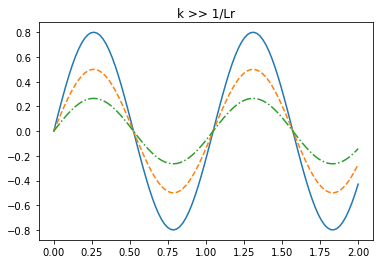

In [384]:
xx = np.linspace(0,2,100)
# Lr = (9.81*1/(10e-4)**2)**1/2

Lr = 1/3
k = 6
plt.title('k >> 1/Lr')

print(k,1/Lr)
print(1/k,Lr)
eta4 = ((((Lr*k)**2)) / (1 + (Lr*k)**2)) * np.sin(k*xx)
plt.plot(xx,eta4,ls='-')

Lr = 1/6
k = 6
plt.title('k >> 1/Lr')

print(k,1/Lr)
print(1/k,Lr)
eta4 = ((((Lr*k)**2)) / (1 + (Lr*k)**2)) * np.sin(k*xx)
plt.plot(xx,eta4,ls='--')


Lr = 1/10
k = 6
print(k,1/Lr)
print(1/k,Lr)
eta4 = ((((Lr*k)**2)) / (1 + (Lr*k)**2)) * np.sin(k*xx)
plt.plot(xx,eta4,ls='-.')

plt.show()